In [12]:
import random
import numpy as np
from deap import base, creator, tools, algorithms
import networkx as nx
import matplotlib.pyplot as plt

In [13]:
stations = ['A', 'B', 'C', 'D', 'E', 'S1', 'S2']
transitions = {
    'S1': ['A', 'B', 'C'],
    'S2': ['A', 'B', 'C', 'D', 'E']
}

In [14]:
lacomotive_type = ['S1', 'S2']

vagon_list = [
    {
        'st': 'A',
    },
    {
        'st': 'A',
    },
    {
        'st': 'A',
    },
    {
        'st': 'A',
    },
    {
        'st': 'A',
    },
    {
        'st': 'A',
    },
    {
        'st': 'B',
    },
    {
        'st': 'B',
    },
    {
        'st': 'B',
    },
    {
        'st': 'C',
    },
    {
        'st': 'C',
    },
    {
        'st': 'C',
    },
    {
        'st': 'D',
    },
    {
        'st': 'D',
    },
    {
        'st': 'E',
    },
    {
        'st': 'E',
    },
    {
        'st': 'E',
    },
]

In [20]:
mul_list = [
    {
        'st': 'A'
    },
    {
        'st': 'B'
    },
    {
        'st': 'B'
    },
]

In [15]:
G = nx.Graph()
color_map = []
color_nodes = ['orange' for _ in range(len(stations))] + ['green' for _ in range(len(vagon_list))]

for key, value in transitions.items():
    for val in value:
        G.add_edge(key, val, color='b', weight=3)
        color_map.append('orange')

for i in range(len(vagon_list)):
    G.add_edge(vagon_list[i]['st'], f"ID: {i}", color='g', weight=1, capacity=15)
    color_map.append('blue')

{'S1': Text(-0.39463489500456517, -0.05310106911566992, 'S1'),
 'A': Text(-0.28338410104160394, 0.6816885724535457, 'A'),
 'B': Text(-0.7764882751759181, -0.3306332337201945, 'B'),
 'C': Text(-0.037878524573182, -0.7529931853805854, 'C'),
 'S2': Text(0.07626834688084479, -0.04545450737489096, 'S2'),
 'D': Text(0.7235869360639728, -0.4806321182723049, 'D'),
 'E': Text(0.7910583998899292, 0.3601786972293804, 'E'),
 'ID: 0': Text(-0.07743121263156837, 0.7686934182241201, 'ID: 0'),
 'ID: 1': Text(-0.22052876013076272, 0.8991074331331218, 'ID: 1'),
 'ID: 2': Text(-0.41888933366274567, 0.8614103276950487, 'ID: 2'),
 'ID: 3': Text(-0.5122445620261447, 0.6907769265519458, 'ID: 3'),
 'ID: 4': Text(-0.40295422266833286, 0.5211482311147004, 'ID: 4'),
 'ID: 5': Text(-0.13120500982878872, 0.5601717434608894, 'ID: 5'),
 'ID: 6': Text(-0.9255060381670873, -0.1755188853257004, 'ID: 6'),
 'ID: 7': Text(-0.9831687070753077, -0.4236987317114074, 'ID: 7'),
 'ID: 8': Text(-0.7543531099128689, -0.5404082061

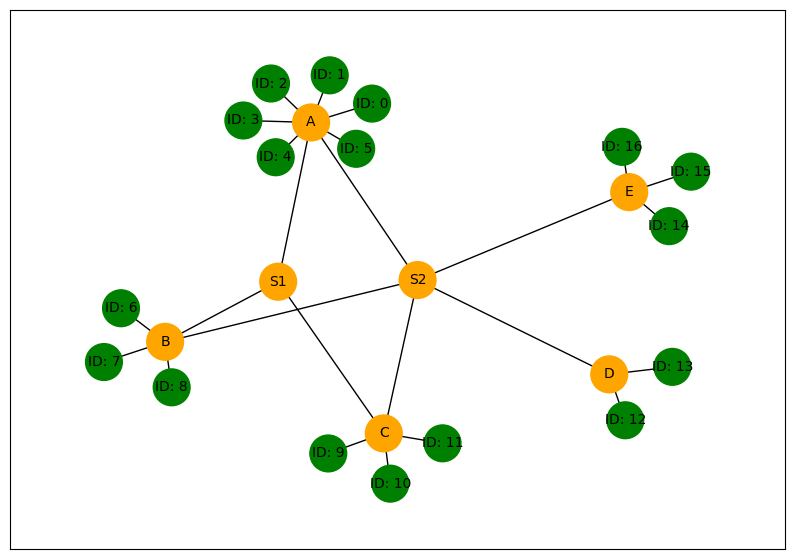

In [16]:
plt.figure(figsize =(10, 7))

pos = nx.kamada_kawai_layout(G,)
nx.draw_networkx_nodes(G, pos, node_size=700, margins=0.1, node_color=color_nodes)
nx.draw_networkx_edges(G, pos)
nx.draw_networkx_labels(G, pos, font_size=10, font_family="sans-serif")

In [21]:
MUL_COUNT = len(mul_list)
OPERATIONS_FOR_MUL = [
    'move_to',
    'cheel'
]
MAX_MUL_OPERATIONS = 10
LENGTH_CHROM = MUL_COUNT * MAX_MUL_OPERATIONS     # длина хромосомы, подлежащей оптимизации
TRAIN_LIVE_TIME = {
    'S1': 5,
    'S2': 6
}

VAGON_OPERATIONS = {
    'idle': 2,
    'move': 8
}

# константы генетического алгоритма
POPULATION_SIZE = 100   # количество индивидуумов в популяции
P_CROSSOVER = 0.9       # вероятность скрещивания
P_MUTATION = 0.2        # вероятность мутации индивидуума
MAX_GENERATIONS = 100    # максимальное количество поколений
HALL_OF_FAME_SIZE = 3

In [18]:
RANDOM_SEED = 0
random.seed(RANDOM_SEED)

In [19]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

In [35]:
def create_individ(max_range, count):
    operations_count = random.randint(1, count)
    res = {
        'commands': []
    }
    for _ in range(count):
        if operations_count > 0:
            new_oper = random.randint(0, max_range)
            if new_oper == 0:
                station = random.choice(stations)
                # vagon_ids = [x for x in range(len(vagon_list)) if vagon_list[i] == st]
                res['commands'].append({f'{new_oper}': {"to": station, "who": random.randint(-1, len(vagon_list))}})
            else:
                res['commands'].append({f'{new_oper}': None})
        else:
            res['commands'].append({'1': None})
        operations_count -= 1
    return res

In [36]:
create_individ(len(OPERATIONS_FOR_MUL) - 1, MAX_MUL_OPERATIONS)

{'commands': [{'0': {'to': 'S1', 'who': 5}},
  {'0': {'to': 'S2', 'who': 4}},
  {'0': {'to': 'C', 'who': 15}},
  {'1': None},
  {'0': {'to': 'E', 'who': 13}},
  {'0': {'to': 'A', 'who': 14}},
  {'1': None},
  {'1': None},
  {'1': None},
  {'1': None}]}

In [37]:
toolbox = base.Toolbox()
toolbox.register("randomOper", create_individ, len(OPERATIONS_FOR_MUL) - 1, MAX_MUL_OPERATIONS)
toolbox.register("individualCreator", tools.initRepeat, creator.Individual, toolbox.randomOper, MUL_COUNT)
toolbox.register("populationCreator", tools.initRepeat, list, toolbox.individualCreator)

In [38]:
population = toolbox.populationCreator(n=MUL_COUNT)
population

[[{'commands': [{'1': None},
    {'1': None},
    {'0': {'to': 'E', 'who': -1}},
    {'1': None},
    {'0': {'to': 'C', 'who': 0}},
    {'1': None},
    {'1': None},
    {'1': None},
    {'1': None},
    {'1': None}]},
  {'commands': [{'0': {'to': 'S2', 'who': 14}},
    {'1': None},
    {'1': None},
    {'1': None},
    {'1': None},
    {'1': None},
    {'1': None},
    {'1': None},
    {'1': None},
    {'1': None}]},
  {'commands': [{'0': {'to': 'S1', 'who': 8}},
    {'1': None},
    {'1': None},
    {'0': {'to': 'A', 'who': 5}},
    {'1': None},
    {'0': {'to': 'B', 'who': 6}},
    {'1': None},
    {'1': None},
    {'1': None},
    {'1': None}]}],
 [{'commands': [{'1': None},
    {'1': None},
    {'0': {'to': 'D', 'who': 17}},
    {'1': None},
    {'0': {'to': 'B', 'who': 13}},
    {'0': {'to': 'C', 'who': 4}},
    {'1': None},
    {'1': None},
    {'1': None},
    {'1': None}]},
  {'commands': [{'0': {'to': 'A', 'who': 14}},
    {'1': None},
    {'1': None},
    {'1': None},
    {'

In [39]:
def train_leave_check(commands: list, curr_step: int) -> (bool, bool):
    "(bool, bool) = (надо ли считать стоимость, надо ли выписать штраф)"
    for train in TRAIN_LIVE_TIME.keys():
        if curr_step < TRAIN_LIVE_TIME[train]: return (True, False)
        for i in range(curr_step-1, -1, -1):
            for key, val in commands[i].items():
                if key == '1' and val == train and TRAIN_LIVE_TIME[train] >= i: return (False, False)
                if key == '1' and val == train and TRAIN_LIVE_TIME[train] < i: return (False, True)
                if key != '0': return (False, True)
    return (True, False)

In [ ]:
PENALITY_COST = max(operations_cost) * 10  # штраф за запрещенную операцию


def shedule_cost(individual):
    current_cost = VAGON_OPERATIONS['idle'] * len(vagon_list) * MAX_MUL_OPERATIONS

    test_vagon_list = vagon_list.copy()
    
    for i in range(MAX_MUL_OPERATIONS):
        pass
    
    for i, mul in enumerate(individual):
        for j, command in enumerate(mul['commands']):
            

    return current_cost,